# Arfima Time Series Simulation

## Table of Contents

[1. Fractional Differencing](#1)

[2. Arfima Simulation testing](#2)

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 13

datasets_folder = "datasets/"

btc = pd.read_csv(datasets_folder + 'coin_Bitcoin.csv')
btc['Date'] = [dt.strptime(x, '%Y-%m-%d %H:%M:%S') for x in btc['Date']]

date_condition = "2017-10-02 23:59:59"
btc = btc.iloc[btc.index[btc["Date"] == date_condition].tolist()[0]:]
btc.set_index('Date', inplace = True)
close_price = btc['Close']
# btc.to_csv('BitcoinTransformed.csv')

In [2]:
%run ArfimaSimulation.ipynb

## 1. Fractional Differencing<a id="1"></a>

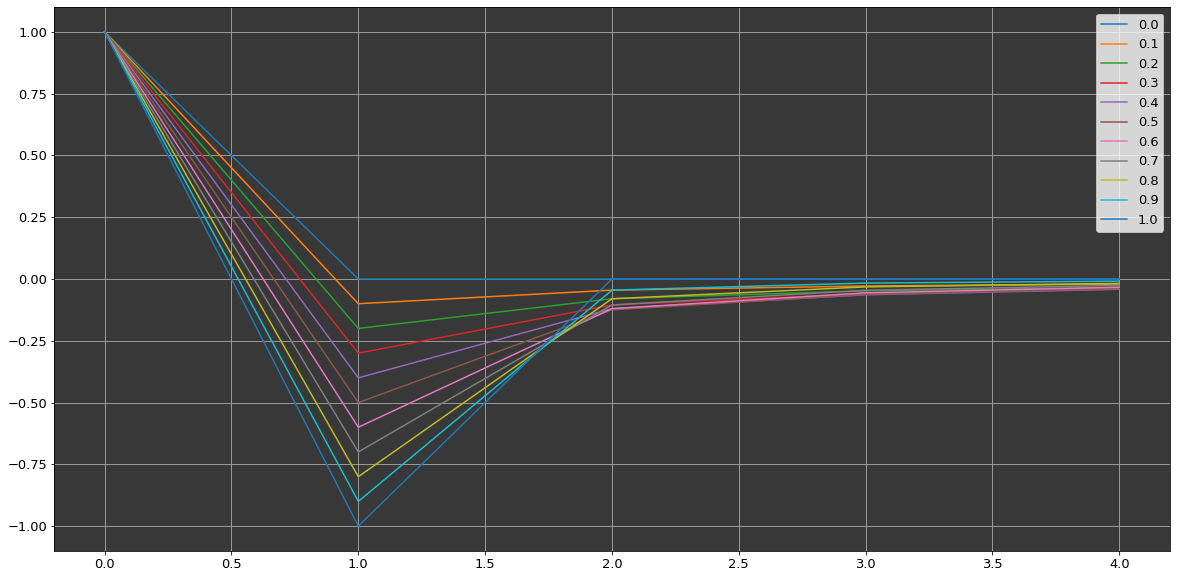

In [3]:
def plot_weights(dRange, nPlots, length):
    w = pd.DataFrame()
    for d in np.linspace(dRange[0], dRange[1], nPlots):
        w_ = get_weights(d, length)     
        w_ = pd.DataFrame(w_, index=range(w_.shape[0])[::-1],
                          columns=[round(d, 2)])
        w = w.join(w_, how='outer')

    w[np.isnan(w)] = 0
    ax = w.plot(figsize=(20,10))
    ax.legend(loc='upper right');
    ax.set_facecolor('#383838')
    ax.grid(True)

    plt.show()

plot_weights(dRange=[0, 1], nPlots=11, length=5)

In [4]:
df_result = fracdiff_FFD(btc[['Close']], 0.4244, 1e-5)
df_result

,Close
2021-04-29 23:59:59,3203.082642
2021-04-30 23:59:59,7823.330475
2021-05-01 23:59:59,6205.595169
2021-05-02 23:59:59,4497.327087
2021-05-03 23:59:59,5314.120970
...,...
2021-07-02 23:59:59,524.492327
2021-07-03 23:59:59,1340.634179
2021-07-04 23:59:59,1691.624475
2021-07-05 23:59:59,-160.562747


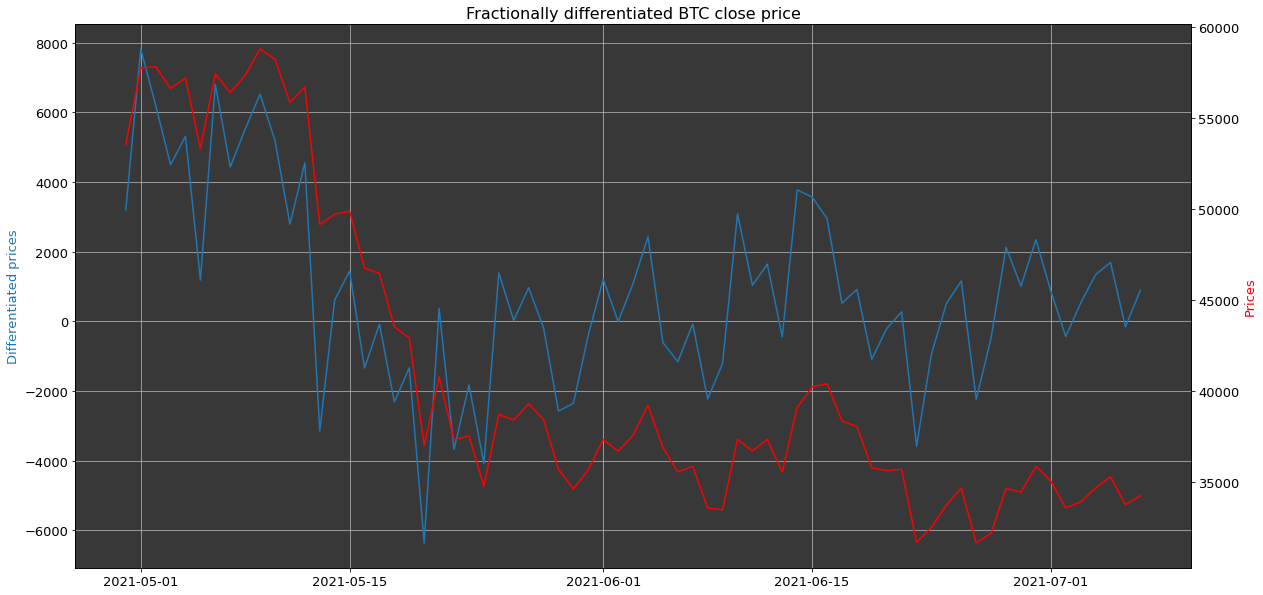

In [5]:
fig, ax1 = plt.subplots(figsize=(20,10))

color1 = 'tab:blue'
ax1.plot(df_result.index, df_result['Close'], color=color1)
ax1.set_facecolor('#383838')
ax1.set_ylabel('Differentiated prices', color=color1)
ax1.set_title('Fractionally differentiated BTC close price',
          fontsize=16)
ax1.grid(True)

color2 = 'red'
ax2 = ax1.twinx()
ax2.plot(df_result.index, btc['Close'].values[-(df_result.shape[0]):], color=color2, label='Prices')
ax2.set_ylabel('Prices', color=color2)
plt.show()

In [6]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(df_result['Close'])
print(f"p-value of BTC: {float(adf[1])}")

p-value of BTC: 0.032108751903561515


## 2. Arfima Simulation testing<a id="2"></a>

In [7]:
from numpy.testing import assert_equal, assert_almost_equal
from statsmodels.tsa.arima.model import ARIMA

In [8]:
# stationary white noise

white_noise = arfima_sim([], 0, [], 1000)
arma = ARIMA(white_noise, order=(0,0,0)).fit()
print(arma.summary())

adf = adfuller(white_noise)
assert_almost_equal(adf[1], 0.00000, decimal=4)

                               SARIMAX Results                                
Dep. Variable:              MA Series   No. Observations:                 1000
Model:                          ARIMA   Log Likelihood               -1412.901
Date:                Wed, 30 Mar 2022   AIC                           2829.801
Time:                        11:36:13   BIC                           2839.617
Sample:                             0   HQIC                          2833.532
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0576      0.032     -1.823      0.068      -0.120       0.004
sigma2         0.9880      0.046     21.327      0.000       0.897       1.079
Ljung-Box (L1) (Q):                   0.95   Jarque-

In [9]:
# stationary ARIMA([0.3, 0.25, 0.4], 1, [0.2], 1000)
    
arima_series = arfima_sim([0.3, 0.25, 0.4], 1, [0.5], 1000, noise_alpha=0.25)
arima = ARIMA(arima_series, order=(3,1,1)).fit()
print(arima.summary())

adf = adfuller(arima_series)
assert_almost_equal(adf[1], 0.00000, decimal=4)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  998
Model:                 ARIMA(3, 1, 1)   Log Likelihood              -21843.880
Date:                Wed, 30 Mar 2022   AIC                          43697.760
Time:                        11:36:15   BIC                          43722.284
Sample:                             0   HQIC                         43707.082
                                - 998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2130      0.106     -2.004      0.045      -0.421      -0.005
ar.L2         -0.2779      0.045     -6.109      0.000      -0.367      -0.189
ar.L3          0.3719      0.041      9.087      0.0

In [10]:
# stationary ARFIMA([0.3], 0.7, [-0.4], 1000])
    
arfima_series = arfima_sim([0.3], 0.7, [-0.4], 1000)

adf = adfuller(arfima_series)
assert_almost_equal(adf[1], 0.00000, decimal=4)

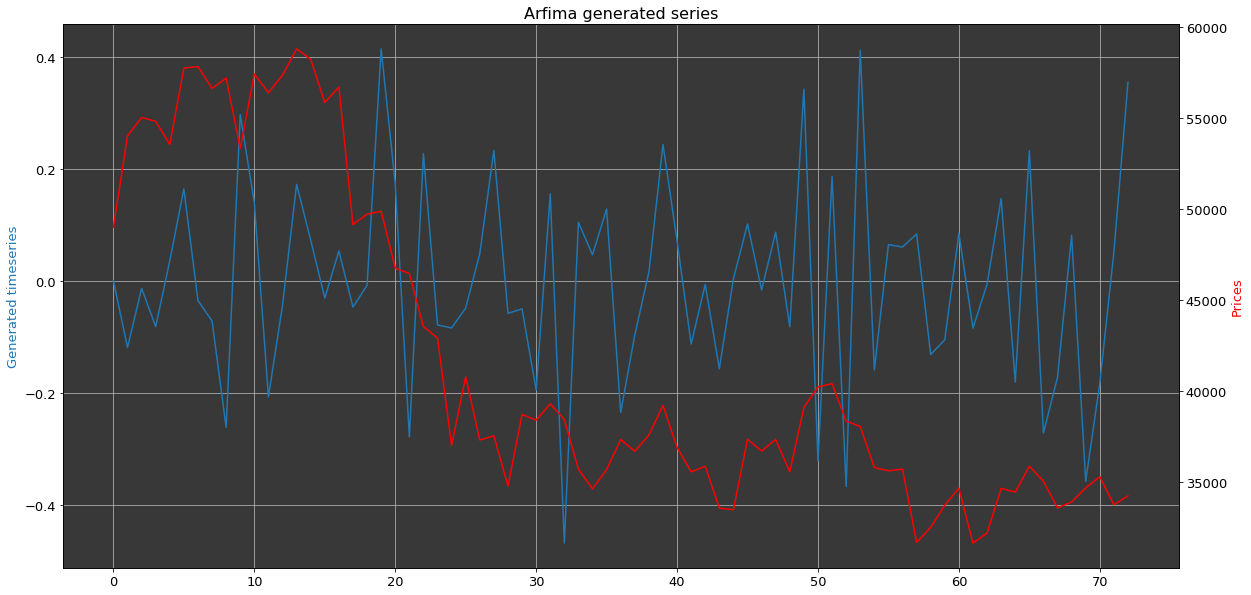

In [11]:
arfima_series = arfima_sim([0.5], 0.5, [-0.4], 1000, noise_std=0.1, noise_alpha=1.8)

fig, ax1 = plt.subplots(figsize=(20,10))

color1 = 'tab:blue'
ax1.plot(np.arange(0, len(arfima_series)), arfima_series, color=color1)
ax1.set_facecolor('#383838')
ax1.set_ylabel('Generated timeseries', color=color1)
ax1.set_title('Arfima generated series', fontsize=16)
ax1.grid(True)

color2 = 'red'
ax2 = ax1.twinx()
ax2.plot(np.arange(0, len(arfima_series)), btc['Close'].values[-(len(arfima_series)):], color=color2, label='Prices')
ax2.set_ylabel('Prices', color=color2)
plt.show()